# CLIP encoder


In [3]:
import sys
sys.path.insert(0, '../Phase 1')

import recipe_parser as rp
import torch
from PIL import Image
import requests 
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModelForCausalLM, CLIPTokenizerFast, CLIPTextConfig, CLIPVisionConfig, CLIPConfig
import matplotlib.pyplot as plt
import pickle
import os

### Device Selection

In [4]:
device =  "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device}. If not using mps, remember to change the .to('mps') to .to(device) in the code")

Using mps. If not using mps, remember to change the .to('mps') to .to(device) in the code


### Model initialization

In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to('cpu')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

### Data Loading

In [6]:
if os.path.exists("../pickle_files/recipes_images.pkl"):
    recipes_images = pickle.load(open("../pickle_files/recipes_images.pkl", "rb"))
else:
    recipes_images = [rp.get_recipes()[key]['images'][0]['url'] for key in rp.get_recipes() if rp.get_recipes()[key]['images'] != []]
    pickle.dump(recipes_images, open("../pickle_files/recipes_images.pkl", "wb"))

In [7]:
if os.path.exists('../pickle_files/recipe_titles.pkl'):
    titles = pickle.load(open('../pickle_files/recipe_titles.pkl', 'rb'))
else:
    titles = rp.get_recipe_titles()

In [8]:
if os.path.exists('../pickle_files/recipe_steps.pkl'):
    steps = pickle.load(open('../pickle_files/recipe_steps.pkl', 'rb'))
else:
    steps = rp.get_recipe_steps()


### Image selection

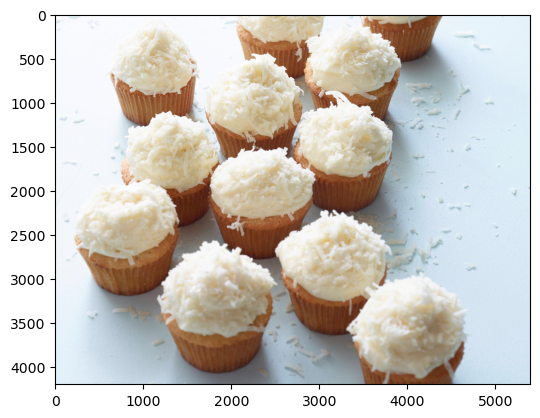

In [9]:
#url = random.choice(recipes_images) 
url = recipes_images[444] #Used to show the use of CLIP to find the step we are in
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.show()

### CLIP Execution for Recipe Selection


In [10]:
inputs = processor(text=titles, images=image, return_tensors="pt", padding=True).to('cpu')
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

### Top Recipe selection

In [11]:
top_k = 5
values, indices = torch.topk(probs, top_k)
index = indices[0][0].item()
print(f"The most probable recipe is: {titles[index]}")

The most probable recipe is: Coconut Cupcakes


### Image Retrieval for Step Visualization


In [12]:
step = steps[index]

step_image_url = 'https://images.immediate.co.uk/production/volatile/sites/30/2022/07/Batter-fb7713d.jpg?quality=90&webp=true&resize=300,272'
step_image = Image.open(requests.get(step_image_url, stream=True).raw)

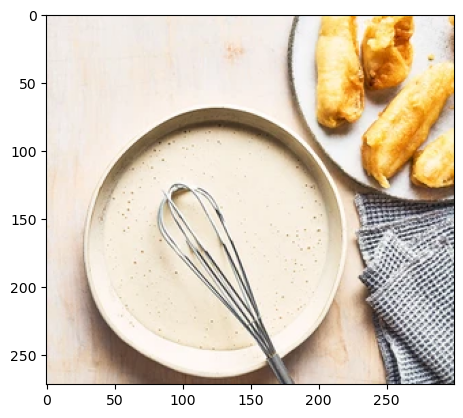

In [13]:
plt.imshow(step_image)
plt.show()

### Process text and image

In [14]:
inputs = processor(text=step, images=[step_image], return_tensors="pt", padding=True)

### Model outputs

In [15]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

### Top prediction and Visualization

In [16]:
#return first value of values
top_k = 3
values, indices = torch.topk(probs, top_k)
print(step[indices[0][0].item()])

In a separate bowl, sift together the flour, baking powder, baking soda, and salt. In 3 parts, alternately add the dry ingredients and the buttermilk to the batter, beginning and ending with the dry. Mix until just combined. Fold in 7 ounces of coconut.
